- In order to execute a Python program, you must type:

``` python <your_program_name>.py ```

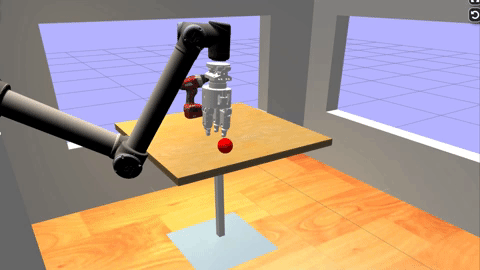

In [ ]:
#arm_control.py
from smart_grasping_sandbox.smart_grasper import SmartGrasper
from tf.transformations import quaternion_from_euler
from math import pi
import time

sgs = SmartGrasper()

sgs.pick()

sgs.reset_world()

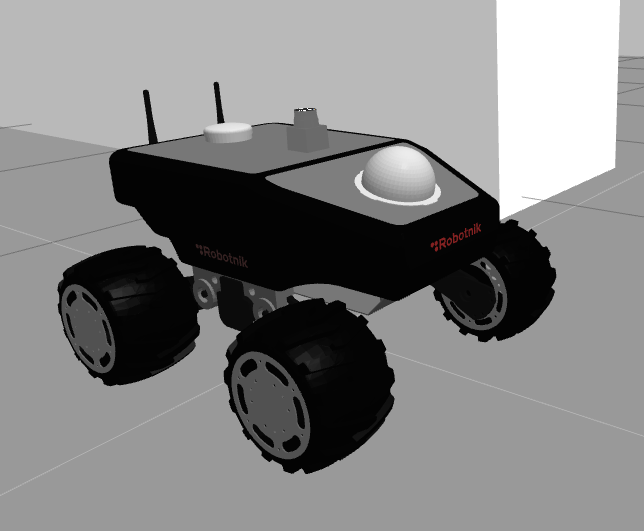

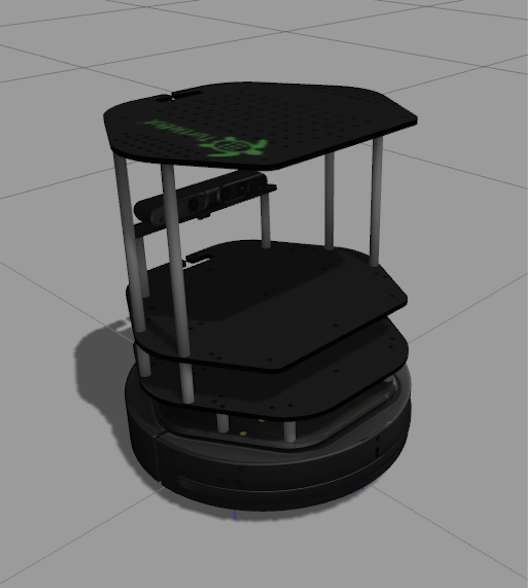

```robot_control_class.py```

In [ ]:
#robot_control_class.py
#!/usr/bin/env python

import rospy
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan
import time


class RobotControl():

    def __init__(self, robot_name="turtlebot"):
        rospy.init_node('robot_control_node', anonymous=True)

        if robot_name == "summit":
            rospy.loginfo("Robot Summit...")
            cmd_vel_topic = "/summit_xl_control/cmd_vel"
            # We check that sensors are working
            self._check_summit_laser_ready()
        else:      
            rospy.loginfo("Robot Turtlebot...")      
            cmd_vel_topic='/cmd_vel'
            self._check_laser_ready()

        # We start the publisher
        self.vel_publisher = rospy.Publisher(cmd_vel_topic, Twist, queue_size=1)
        self.cmd = Twist()        

        self.laser_subscriber = rospy.Subscriber(
            '/kobuki/laser/scan', LaserScan, self.laser_callback)
        self.summit_laser_subscriber = rospy.Subscriber(
            '/hokuyo_base/scan', LaserScan, self.summit_laser_callback)
        
        self.ctrl_c = False
        self.rate = rospy.Rate(1)
        rospy.on_shutdown(self.shutdownhook)

    
    def _check_summit_laser_ready(self):
        self.summit_laser_msg = None
        rospy.loginfo("Checking Summit Laser...")
        while self.summit_laser_msg is None and not rospy.is_shutdown():
            try:
                self.summit_laser_msg = rospy.wait_for_message("/hokuyo_base/scan", LaserScan, timeout=1.0)
                rospy.logdebug("Current /hokuyo_base/scan READY=>" + str(self.summit_laser_msg))

            except:
                rospy.logerr("Current /hokuyo_base/scan not ready yet, retrying for getting scan")
        rospy.loginfo("Checking Summit Laser...DONE")
        return self.summit_laser_msg

    def _check_laser_ready(self):
        self.laser_msg = None
        rospy.loginfo("Checking Laser...")
        while self.laser_msg is None and not rospy.is_shutdown():
            try:
                self.laser_msg = rospy.wait_for_message("/kobuki/laser/scan", LaserScan, timeout=1.0)
                rospy.logdebug("Current /kobuki/laser/scan READY=>" + str(self.laser_msg))

            except:
                rospy.logerr("Current /kobuki/laser/scan not ready yet, retrying for getting scan")
        rospy.loginfo("Checking Laser...DONE")
        return self.laser_msg

    def publish_once_in_cmd_vel(self):
        """
        This is because publishing in topics sometimes fails the first time you publish.
        In continuous publishing systems, this is no big deal, but in systems that publish only
        once, it IS very important.
        """
        while not self.ctrl_c:
            connections = self.vel_publisher.get_num_connections()
            if connections > 0:
                self.vel_publisher.publish(self.cmd)
                #rospy.loginfo("Cmd Published")
                break
            else:
                self.rate.sleep()

    def shutdownhook(self):
        # works better than the rospy.is_shutdown()
        self.ctrl_c = True

    def laser_callback(self, msg):
        self.laser_msg = msg

    def summit_laser_callback(self, msg):
        self.summit_laser_msg = msg

    def get_laser(self, pos):
        time.sleep(1)
        return self.laser_msg.ranges[pos]

    def get_laser_summit(self, pos):
        time.sleep(1)
        return self.summit_laser_msg.ranges[pos]

    def get_front_laser(self):
        time.sleep(1)
        return self.laser_msg.ranges[360]

    def get_laser_full(self):
        time.sleep(1)
        return self.laser_msg.ranges

    def stop_robot(self):
        #rospy.loginfo("shutdown time! Stop the robot")
        self.cmd.linear.x = 0.0
        self.cmd.angular.z = 0.0
        self.publish_once_in_cmd_vel()

    def move_straight(self):

        # Initilize velocities
        self.cmd.linear.x = 0.5
        self.cmd.linear.y = 0
        self.cmd.linear.z = 0
        self.cmd.angular.x = 0
        self.cmd.angular.y = 0
        self.cmd.angular.z = 0

        # Publish the velocity
        self.publish_once_in_cmd_vel()

    def move_straight_time(self, motion, speed, time):

        # Initilize velocities
        self.cmd.linear.y = 0
        self.cmd.linear.z = 0
        self.cmd.angular.x = 0
        self.cmd.angular.y = 0
        self.cmd.angular.z = 0

        if motion == "forward":
            self.cmd.linear.x = speed
        elif motion == "backward":
            self.cmd.linear.x = - speed

        i = 0
        # loop to publish the velocity estimate, current_distance = velocity * (t1 - t0)
        while (i <= time):

            # Publish the velocity
            self.vel_publisher.publish(self.cmd)
            i += 1
            self.rate.sleep()

        # set velocity to zero to stop the robot
        self.stop_robot()

        s = "Moved robot " + motion + " for " + str(time) + " seconds at " + str(speed) + "  m/s"
        return s


    def turn(self, clockwise, speed, time):

        # Initilize velocities
        self.cmd.linear.x = 0
        self.cmd.linear.y = 0
        self.cmd.linear.z = 0
        self.cmd.angular.x = 0
        self.cmd.angular.y = 0

        if clockwise == "clockwise":
            self.cmd.angular.z = -speed
        else:
            self.cmd.angular.z = speed

        i = 0
        # loop to publish the velocity estimate, current_distance = velocity * (t1 - t0)
        while (i <= time):

            # Publish the velocity
            self.vel_publisher.publish(self.cmd)
            i += 1
            self.rate.sleep()

        # set velocity to zero to stop the robot
        self.stop_robot()

        s = "Turned robot " + clockwise + " for " + str(time) + " seconds at " + str(speed) + "  radians/second"
        return s


if __name__ == '__main__':
    
    robotcontrol_object = RobotControl()
    try:
        robotcontrol_object.move_straight()

    except rospy.ROSInterruptException:
        pass

``` pyscript1.py ```

In [ ]:
from robot_control_class import RobotControl

rc = RobotControl()

a = rc.get_laser(360)

print ("The distance measured is: ", a, " m.")

- What is this get_laser() method?

The method `get_laser (ray_number)`: this method allows you to get data from the laser of the robot. When you call this method, it will return the distance measured by the laser ray that you specify as the parameter.
The parameter `ray_number`: here is where you specify a number between 0 and 719, which will indicate the ray of the laser reading you want to get the measured distance.
Right now, this may sound a bit confusing, so let's try to explain it. As you can see in the Turtlebot robot in the simulation, it has a laser mounted on its top plate.

<img src="../Figuras/turtle_laser.png" width="300px">

<img src="../Figuras/turtle_laser3.png" width="800px">

``variables.py``

In [ ]:
from robot_control_class import RobotControl

robotcontrol = RobotControl()

laser1 = robotcontrol.get_laser(0)
print ("The laser value received is: ", laser1)

laser2 = robotcontrol.get_laser(360)
print ("The laser value received is: ", laser2)

laser2 = robotcontrol.get_laser(719)
print ("The laser value received is: ", laser2)

`lists.py`

In [ ]:
from robot_control_class import RobotControl

rc = RobotControl()

l = rc.get_laser_full()

print ("Position 0: ", l[0])
print ("Position 360: ", l[360])
print ("Position 719: ", l[719])

`dictionaries.py`

In [ ]:
from robot_control_class import RobotControl

rc = RobotControl()

l = rc.get_laser_full()

dict = {"P0": l[0], "P100": l[100], "P200": l[200], "P300": l[300], "P400": l[400], "P500": l[500], "P600": l[600], "P719": l[719]}

print (dict)

`test_input.py`

In [ ]:
from robot_control_class import RobotControl

num = int(input("Select a number between 0 and 719: "))

rc = RobotControl()
a = rc.get_laser(num)

print ("The laser value received is: ", a)

<img src="../Figuras/flowchart_new.png" width="500px">

`pseudocodigo`

In [ ]:
if wall_is_close:
    stop_robot() 
    
else:
    keep_moving()
    
print_reading()

In [ ]:
if condition:
    statement
    statement
    # ... some more statements if necessary

In [ ]:
if condition:
    # Indented statements
    statement
    statement

else:
    # Indented statements
    statement
    statement

In [ ]:
if condition_1:
    statement_block_1
elif condition_2:
    statement_block_2

...

elif another_condition:    
    another_statement_block
else:
    else_block

<img src="../Figuras/testif_gif.gif" width="600px">

In [ ]:
from robot_control_class import RobotControl

robotcontrol = RobotControl()

a = robotcontrol.get_laser(360)

if a < 1:
    robotcontrol.stop_robot()

else:
    robotcontrol.move_straight()

print ("The laser value received was: ", a)

<img src="../Figuras/flowchart_loop.png" width="600px">

In [ ]:
while wall_is_not_closer_than_1meter:
    keep_moving()
    
stop_robot()

<img src="../Figuras/testwhile_gif.gif" width="600px">

In [ ]:
from robot_control_class import RobotControl

robotcontrol = RobotControl()

a = robotcontrol.get_laser(360)

while a > 1:
    robotcontrol.move_straight()
    a = robotcontrol.get_laser(360)
    print ("Current distance to wall: %f" % a)

robotcontrol.stop_robot()

print ("Wall is at %f meters! Stop the robot!" % a)

In [ ]:
from robot_control_class import RobotControl

robotcontrol = RobotControl()

l = robotcontrol.get_laser_full()

maxim = 0

for value in l:
    if value > maxim:
        maxim = value

print ("The higher value in the list is: ", maxim)

- Methods

A method in Python is defined by a def statement. The general syntax looks like this:


```python
def mymethod():
    print ("Python")
```

Para chamar o método:

In [ ]:
def mymethod():
    print ("The method mymethod() has been called")
    
mymethod()

In [ ]:
from robot_control_class import RobotControl
import time

robotcontrol = RobotControl(robot_name="summit")

def move_x_seconds(secs):
    robotcontrol.move_straight()
    time.sleep(secs)
    robotcontrol.stop_robot()


move_x_seconds(5)

In [ ]:
from robot_control_class import RobotControl

robotcontrol = RobotControl(robot_name="summit")

def get_laser_values(a,b,c):
    r1 = robotcontrol.get_laser_summit(a)
    r2 = robotcontrol.get_laser_summit(b)
    r3 = robotcontrol.get_laser_summit(c)

    return [r1, r2, r3]

l = get_laser_values(0, 500, 1000)

print ("Reading 1: ", l[0])
print ("Reading 2: ", l[1])
print ("Reading 3: ", l[2])